### Hello! 
Thank you for taking the time to do Depop's coding test 🙏.  

The project is trying to catch keyword spamming 🍖, which is when sellers will name loads of unrelated, irrelevant brands in the description of the item they're selling 👗 to improve their ranking in the search page 📈. The buyer's experience is that they search for 'Levi Jeans' 👖, but see Diesel jeans ⛽️ highly ranked, because the seller spammed the keyword 'Levi' in their product description. This is frustrating for the buyer 😖. If we can classify item descriptions as 'spammy' 🍖, we can demote the item in the ranking algorithm 📉. This piece of work is trying to build that classifier 🔨.   
  
This test imagines you are doing a PR for a junior data scientist's work 🤓. As you will see, there are a bunch of errors:
- Some errors in ML logic 🔬
- Limited features
- Badly tuned model
- It lacks structure 🏗 (perhaps because it's in a notebook)
- It's unpythonic in places
- And generally it needs a bunch of improvement 🛠.   
  
Usually, of course, you would leave educational comments in the PR to coach your colleague's development 👩🏾‍🏫, but in this instance, please take over the work and get it to your high standards 🏆. Please spend at most couple of hours improving it. There's too much going on to perfect everything and build a best in class model, so prioritise the things you think are the most important over that time. Then let us know further changes you would make but have not had time ⏰, and suggest next steps 🧗🏿‍♀️ for the project.  
  
Please focus on:  
- Model correctness
- Data preparation
- Maintainability of code
- Likelihood to succeed in production

You'll submit the work in two days' time, and have time to explain your thoughts and decisions in an interview after that.

In [1]:
## This code is only for my notebook to load the data 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls -al /content/drive/MyDrive/Depop

total 3080
-rw------- 1 root root 1156415 Jan 24 06:12 'Classifying Keyword Spamming_v1.ipynb'
-rw------- 1 root root  666719 Jan 22 04:50 'ml-coding-test_(1).zip'
-rw------- 1 root root      58 Jan 22 05:01  requirements.txt
-rw------- 1 root root  317847 Jan 22 05:01  test_set.tsv
-rw------- 1 root root 1011487 Jan 22 05:01  train_set.tsv


You'll need to download en_core_web_sm for this task

In [3]:
! python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 4.8 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
! pip install truecase

     |████████████████████████████████| 28.4 MB 1.6 MB/s 


In [5]:
! pip install Unidecode

     |████████████████████████████████| 235 kB 5.0 MB/s 


In [6]:
from itertools import chain
import os
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
import spacy
import truecase
import xgboost as xgb
import unidecode
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
nlp = spacy.load("en_core_web_sm")

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Collection

In [8]:

## Function to read data from files...
def read_data(filename):
  cwd = os.getcwd()
  filepath = os.path.join(cwd, filename)
  if(os.path.exists(filepath)):
    data = pd.read_csv(filepath, sep="\t")[["product_id", "description", "label"]]
    return data
  else:
    print(f'The file {filepath} does not exist')



In [9]:
train = read_data("drive/MyDrive/Depop/train_set.tsv")
test =  read_data("drive/MyDrive/Depop/test_set.tsv")


df = pd.concat([train, test], axis=0)

df = df.reset_index(drop=True)
df[:2]

product_id  \
0   180202844   
1   178987418   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             super cute high waisted blue jeans. recommended for shorter / petite girls, i'm 5'1 and it fits me perfect. (example shown in last pic)  these are more of jeggings than jeans and have a polyester material inside.  only flaw: the zipper goes down by itself sometimes   branded for exposure  size 0 / waist 23   
1  Jordan 5 P51 Camo Size 9 Good condition  Soles have yellowing  No box or lacelocks  $160    Travis Supreme concepts Jordan 1 3 5 6 7 11 12 Nike ovo Kanye yeezy boost 350 shadow royal bred shattered cement top 3 black toe infrared raptor gamma space jam air max vapormax flyknit Travis Scott kaws off white atmos 95 97 98 silver gold bullet protro Kobe fieg kith Levi’s undefeated Palace tinker stash SB dunk stone island Foamposite plus Acronym VF Wotherspoon 270 SW LeBron Kyrie Pippen Metallic Penny Orlando Dunkman Eggplant Chrome All Star Pearl Camo JTH powder olive protro presto off white butter He got game cdg bogo Paris saint Germain Court purple pine green blazer union diamond Dunk cdg staple pigeon Diamond resale bape Zoom fly concord union Purple lobster concepts 997  converse homage   

   label  
0      0  
1      1

## Data Preprocessing

In [10]:
def proportion_of_stopwords(description):
    tokens = description.split(" ")
    num_stopwords = len(
        [word for word in tokens if word.lower() in nlp.Defaults.stop_words]
    )
    return float(num_stopwords) / float(len(tokens)) if len(tokens) else 0.0


def average_length_of_word(description):
    tokens = description.split(" ")
    return np.mean([len(word) for word in tokens]) if len(tokens) else 0.0


def proportion_of_numbers(description):
    tokens = description.split(" ")
    num_digits = len([word for word in tokens if word.isdigit()])
    return float(num_digits) / float(len(tokens)) if len(tokens) else 0.0


def normalise_nonascii_chars(input_str):
    return unidecode.unidecode(input_str)


def replace_special_chars(main_string):
    return re.sub("[,;@#!\?\+\*\n\-: /]", " ", main_string)


def keep_alphanumeric_chars(string_input):
    return re.sub("[^A-Za-z0-9& ]", "", string_input)


def remove_spaces(string_input):
    return " ".join(string_input.split())


def lemmatize(string_input):
    token_object = nlp(string_input)
    lemmas_list = [
        word.lemma_ if word.lemma_ != "-PRON-" else word.text for word in token_object
    ]
    return " ".join(lemmas_list)

# function for removing stop words
def remove_stopwords(string_input):
  output= [i for i in string_input if i not in nlp.Defaults.stop_words]
  return output

def clean_description(input_str):
    input_str = replace_special_chars(input_str.lower())
    input_str = normalise_nonascii_chars(input_str)
    input_str = keep_alphanumeric_chars(input_str)
    input_str = lemmatize(input_str)
    input_str = remove_spaces(input_str)
    return input_str


## Feature Extraction and New Feature Creation

In [11]:
df['description'] = df['description'].apply(clean_description)

for i in ['proportion_of_stopwords', 'average_length_of_word', 'proportion_of_numbers']:
    df[i] = df['description'].apply(eval(i))
    
df[:1]    

product_id  \
0   180202844   

                                                                                                                                                                                                                                                                           description  \
0  super cute high waiste blue jean recommend for short petite girl i be 51 and it fit me perfect example show in last pic these be more of jegging than jean and have a polyester material inside only flaw the zipper go down by itself sometimes brand for exposure size 0 waist 23   

   label  proportion_of_stopwords  average_length_of_word  \
0      0                 0.471698                4.207547   

   proportion_of_numbers  
0               0.056604

## Have a go at identifying brands, and nouns likely to be spammed

In [12]:
def drop_digits(s):
    return "".join([i for i in s if not i.isdigit()])


df["description"] = df["description"].apply(drop_digits)
# .ents only stands a chance with capitalized words
df["description_truecase"] = df["description"].apply(truecase.get_true_case)
df["description_nlp"] = df["description_truecase"].apply(nlp)

df["named_entities"] = ""
for i, description_nlp in df["description_nlp"].iteritems():
    named_entities_sets = description_nlp.ents
    named_entities = list(set(chain(*named_entities_sets)))
    df["named_entities"].iloc[i] = " ".join(j.text for j in named_entities)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [49]:
df.head(2)

product_id  \
0   180202844   
1   178987418   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               super cute high waiste blue jean recommend for short petite girl i be  and it fit me perfect example show in last pic these be more of jegging than jean and have a polyester material inside only flaw the zipper go down by itself sometimes brand for exposure size  waist    
1  jordan  p camo size  good condition sol have yellow no box or lacelock  travis supreme concepts jordan        nike ovo kanye yeezy boost  shadow royal breed shatter cement top  black toe infrare raptor gamma space jam air max vapormax flyknit travis scott kaw off white atmos    silver gold bullet protro kobe fieg kith levis undefeated palace tinker stash sb dunk stone island foamposite plus acronym vf wotherspoon  sw lebron kyrie pippen metallic penny orlando dunkman eggplant chrome all star pearl camo jth powder olive protro presto off white butter he get game cdg bogo paris saint germain court purple pine green blazer union diamond dunk cdg staple pigeon diamond resale bape zoom fly concord union purple lobster concept  converse homage   

   label  proportion_of_stopwords  average_length_of_word  \
0      0                 0.471698                4.207547   
1      1                 0.066176                4.735294   

   proportion_of_numbers  \
0               0.056604   
1               0.125000   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description_truecase  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Super cute high Waiste blue Jean recommend for short Petite girl I be and it fit me perfect example show in last PIC these be more of Jegging than Jean and have a polyester material inside only flaw the Zipper go dow

## Vectorise the top 500 named entities

In [13]:
vectorizer_named_entities = TfidfVectorizer(
    stop_words=nlp.Defaults.stop_words, max_features=500
)
df_tfidf_named_entities = pd.DataFrame(
    vectorizer_named_entities.fit_transform(df["named_entities"]).todense(),
    columns=vectorizer_named_entities.get_feature_names(),
)
df_tfidf_named_entities.columns = [
    f"{i}_named_entities" for i in df_tfidf_named_entities.columns
]
df = pd.concat([df, df_tfidf_named_entities], axis=1)
df[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


product_id  \
0   180202844   
1   178987418   
2   179026287   
3   179777475   
4   179251995   
5   180476748   
6   180194571   
7   179806965   
8   178974087   
9   179120050   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   super cute high waiste blue jean recommend for short petite girl i be  and it fit me perfect example show in last pic these be more of jegging than jean and have a polyester material inside only flaw the zipper go down by itself sometimes brand for exposure size  waist    
1                                                                                                                                                                                      jordan  p camo size  good condition sol have yellow no box or lacelock  travis supreme concepts jordan        nike ovo kanye yeezy boost  shadow royal breed shatter cement top  black toe infrare raptor gamma space jam air max vapormax flyknit travis scott kaw off white atmos    silver gold bullet protro kobe fieg kith levis undefeated palace tinker stash sb dunk stone island foamposite plus acronym vf wotherspoon  sw lebron kyrie pippen metallic penny orlando dunkman eggplant chrome all star pearl camo jth powder olive protro presto off white butter he get game cdg bogo paris saint germain court purple pine green blazer union diamond dunk cdg staple pigeon diamond resale bape zoom fly concord union purple lobster concept  converse homage   
2  lovely baby blue karen millen scoop neck cardigan so cute and elegant xxx yk  s s fendi vintage streetwear festival summer versace moschino nastygal topshop ratandboa brandy melville sportsbra urbanoutfitters gucci playboy remake louisvuitton dolce&gabbana bikini chanel cami corset chinese oriental bodycon dress top t shirt fluffy oversized big moon sun stripe tie dye short trouser skirt monogram leopard camo sleeve slit tight short mini top line mesh black off the shoulder strapless bandeau floral silver gold bead beaded shorts mini black bikini red sheer hoodie zip rip jean mom flare flare star lace graphic denim rib fur silk satin linen stretchy shiny halter tie up baby pink blue white cherry snake snakeskin animal print glittery sparkly bodysuit boob tube check gingham embroidered crochet high waist velour flame cargo ann summers beaux avenue ted baker calvin klein tommy hilfiger karen millen french connection   
3                                                                              

## Vectorise the top 500 description words

In [14]:
vectorizer_description = TfidfVectorizer(
    stop_words=nlp.Defaults.stop_words, max_features=500
)
df_tfidf_description = pd.DataFrame(
    vectorizer_description.fit_transform(df["description"]).todense(),
    columns=vectorizer_description.get_feature_names(),
)
df_tfidf_description.columns = [
    f"{i}_description" for i in df_tfidf_description.columns
]
df = pd.concat([df, df_tfidf_description], axis=1)
df[:1]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


product_id  \
0   180202844   

                                                                                                                                                                                                                                                                      description  \
0  super cute high waiste blue jean recommend for short petite girl i be  and it fit me perfect example show in last pic these be more of jegging than jean and have a polyester material inside only flaw the zipper go down by itself sometimes brand for exposure size  waist    

   label  proportion_of_stopwords  average_length_of_word  \
0      0                 0.471698                4.207547   

   proportion_of_numbers  \
0               0.056604   

                                                                                                                                                                                                                                                          description_truecase  \
0  Super cute high Waiste blue Jean recommend for short Petite girl I be and it fit me perfect example show in last PIC these be more of Jegging than Jean and have a polyester material inside only flaw the Zipper go down by itself sometimes brand for exposure size waist   

                                                                                                                                                                                                                                                                                                                  description_nlp  \
0  (Super, cute, high, Waiste, blue, Jean, recommend, for, short, Petite, girl, I, be, and, it, fit, me, perfect, example, show, in, last, PIC, these, be, more, of, Jegging, than, Jean, and, have, a, polyester, material, inside, only, flaw, the, Zipper, go, down, by, itself, sometimes, brand, for, exposure, size, waist)   

                    named_entities  abercrombie_named_entities  \
0  Zipper Jean Petite Jean Jegging                         0.0   

   accessorie_named_entities  adida_named_entities  adidas_named_entities  \
0                        0.0                   0.0                    0.0   

   af_named_entities  air_named_entities  airmax_named_entities  \
0                0.0                 0.0                    0.0   

   alexander_named_entities  alice_named_entities  amara_named_entities  \
0                       0.0                   0.0                   0.0   

   american_named_entities  angel_named_entities  angeles_named_entities  \
0                      0.0                   0.0                     0.0   

   anime_named_entities  arden_named_entities  argyle_named_entities  \
0                   0.0                   0.0                    0.0   

   ariana_named_entities  ashley_named_entities  ashlyn_named_entities  \
0                    0.0                    0.0                    0.0   

   asos_named_entities  aus_named_entities  australia_named_entities  \
0                  0.0                 0.0                       0.0   

   babe_named_entities  babydoll_named_entities  babygirl_named_entities  \
0                  0.0                      0.0                      0.0   

   backless_named_entities  baddie_named_entities  baguette_named_entities  \
0                      0.0                    0.0                      0.0   

   baker_named_entities  balenciaga_named_entities  bandana_named_entities  \
0                   0.0                        0.0                     0.0   

   bandeau_named_entities  bape_named_entities  barbie_named_entities  \
0                     0.0                  0.0                    0.0   

   bardot_named_entities  barkingmadz_named_entities  bay_named_entities  \
0                    0.0                         0.0                 0.0   

   beach_named_entities  bead_named_entities  beanie_named_entities  \
0                   0.0      

## Get data ready for modelling

In [15]:
df = df.drop(
    ["description", "description_truecase", "description_nlp", "named_entities"], axis=1
)
df[:1]

product_id  label  proportion_of_stopwords  average_length_of_word  \
0   180202844      0                 0.471698                4.207547   

   proportion_of_numbers  abercrombie_named_entities  \
0               0.056604                         0.0   

   accessorie_named_entities  adida_named_entities  adidas_named_entities  \
0                        0.0                   0.0                    0.0   

   af_named_entities  air_named_entities  airmax_named_entities  \
0                0.0                 0.0                    0.0   

   alexander_named_entities  alice_named_entities  amara_named_entities  \
0                       0.0                   0.0                   0.0   

   american_named_entities  angel_named_entities  angeles_named_entities  \
0                      0.0                   0.0                     0.0   

   anime_named_entities  arden_named_entities  argyle_named_entities  \
0                   0.0                   0.0                    0.0   

   ariana_named_entities  ashley_named_entities  ashlyn_named_entities  \
0                    0.0                    0.0                    0.0   

   asos_named_entities  aus_named_entities  australia_named_entities  \
0                  0.0                 0.0                       0.0   

   babe_named_entities  babydoll_named_entities  babygirl_named_entities  \
0                  0.0                      0.0                      0.0   

   backless_named_entities  baddie_named_entities  baguette_named_entities  \
0                      0.0                    0.0                      0.0   

   baker_named_entities  balenciaga_named_entities  bandana_named_entities  \
0                   0.0                        0.0                     0.0   

   bandeau_named_entities  bape_named_entities  barbie_named_entities  \
0                     0.0                  0.0                    0.0   

   bardot_named_entities  barkingmadz_named_entities  bay_named_entities  \
0                    0.0                         0.0                 0.0   

   beach_named_entities  bead_named_entities  beanie_named_entities  \
0                   0.0                  0.0                    0.0   

   bebe_named_entities  bella_named_entities  belle_named_entities  \
0                  0.0                   0.0                   0.0   

   bershka_named_entities  betty_named_entities  bikini_named_entities  \
0                     0.0                   0.0                    0.0   

   billie_named_entities  black_named_entities  blair_named_entities  \
0                    0.0                   0.0                   0.0   

   blogger_named_entities  blue_named_entities  bnwt_named_entities  \
0                     0.0                  0.0                  0.0   

   bodycon_named_entities  bodysuit_named_entities  bohemian_named_entities  \
0                     0.0                      0.0                      0.0   

   boho_named_entities  boob_named_entities  boohoo_named_entities  \
0                  0.0                  0.0                    0.0   

   boop_named_entities  boujee_named_entities  boyfriend_named_entities  \
0                  0.0                    0.0                       0.0   

   bra_named_entities  braid_named_entities  bralet_named_entities  \
0                 0.0                   0.0                    0.0   

   bralette_named_entities  brandy_named_entities  \
0                      0.0                    0.0   

   brandymelville_named_entities  brat_named_entities  bratz_named_entities  \
0                            0.0                  0.0                   0.0   

   broderie_named_entities  brown_named_entities  bts_named_entities  \
0                      0.0                   0.0                 0.0   

   bubblegum_named_entities  buffalo_named_entities  burberry_named_entities  \
0                       0.0                     0.0                      0.0   

   bustier_named_entities  butterfly_named_entities  \
0  

In [16]:
### Check Whether Data is balanced or not

In [16]:
desc_spam = df[df['label'] == 1 ]
desc_spam.shape

(1161, 1005)

In [17]:
desc_not_spam = df[df['label'] == 0 ]
desc_not_spam.shape

(839, 1005)

In [24]:
### Here data is almost balanced

## Split into train and test

In [18]:
X_train = df.drop("label", axis=1)
y_train = df["label"]
X_test = df[df["product_id"].isin(list(test["product_id"]))].drop("label", axis=1)
y_test = df[df["product_id"].isin(list(test["product_id"]))]["label"]

## Fit model

In [19]:
param_dist = {"objective": "binary:logistic", "n_estimators": 2}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="logloss",
    verbose=True,
)

[0]	validation_0-logloss:0.651179	validation_1-logloss:0.646528
[1]	validation_0-logloss:0.612497	validation_1-logloss:0.600807


XGBClassifier(n_estimators=2)

## Predict on model

In [20]:
y_pred = clf.predict(X_test)

In [ ]:
### Feature Importance 

In [21]:
features = pd.DataFrame(
    zip(X_train.columns, clf.feature_importances_),
    columns=["feature_name", "feature_importance"],
)
features.sort_values("feature_importance", ascending=False)

feature_name  feature_importance
1000                  yk_description            0.347620
981              vintage_description            0.158998
2             average_length_of_word            0.115372
3              proportion_of_numbers            0.091909
809                 nike_description            0.090062
913                skirt_description            0.076969
495                yk_named_entities            0.045379
329              nike_named_entities            0.041820
726               ignore_description            0.031871
667                  fit_description            0.000000
670               fleece_description            0.000000
669                 flaw_description            0.000000
668                flare_description            0.000000
0                         product_id            0.000000
666                 fila_description            0.000000
672               flower_description            0.000000
665             festival_description            0.000000
664                 feel_description            0.000000
663                 faux_description            0.000000
662              fashion_description            0.000000
671               floral_description            0.000000
676                 free_description            0.000000
673               fluffy_description            0.000000
674                force_description            0.000000
675              forever_description            0.000000
660                fairy_description            0.000000
677                funky_description            0.000000
678                  fur_description            0.000000
679                  gal_description            0.000000
680                 galt_description            0.000000
681              genuine_description            0.000000
682                  gia_description            0.000000
683                 gift_description            0.000000
684                 gina_description            0.000000
685              gingham_description            0.000000
686                 girl_description            0.000000
661                 fall_description            0.000000
657             exposure_description            0.000000
659                 face_description            0.000000
658                extra_description            0.000000
631                depop_description            0.000000
632          depopfamous_description            0.000000
633               design_description            0.000000
634             designer_description            0.000000
635               detail_description            0.000000
636              diamond_description            0.000000
637                 dior_description            0.000000
638                disco_description            0.000000
639             discount_description            0.000000
640               disney_description            0.000000
641                   dm_description            0.000000
642                  doc_description            0.000000
643                 doll_description            0.000000
644            dollskill_description            0.000000
645                   dr_description            0.000000
646                dress_description            0.000000
647                  dye_description            0.000000
648                eagle_description            0.000000
649                early_description            0.000000
650              earring_description            0.000000
651                 edgy_description            0.000000
652                egirl_description            0.000000
653            embroider_description            0.000000
654           embroidery_description            0.000000
655                  emo_description            0.000000
656            excellent_description            0.000000
688              glitter_description            0.000000
687                girly_description            0.000000
692                 goth_description            0.000000
689                 gold_descripti

In [22]:
features_list = features[features['feature_importance'] > 0.000000 ]
features_list = features_list.sort_values("feature_importance", ascending=False)
features_list

feature_name  feature_importance
1000          yk_description            0.347620
981      vintage_description            0.158998
2     average_length_of_word            0.115372
3      proportion_of_numbers            0.091909
809         nike_description            0.090062
913        skirt_description            0.076969
495        yk_named_entities            0.045379
329      nike_named_entities            0.041820
726       ignore_description            0.031871

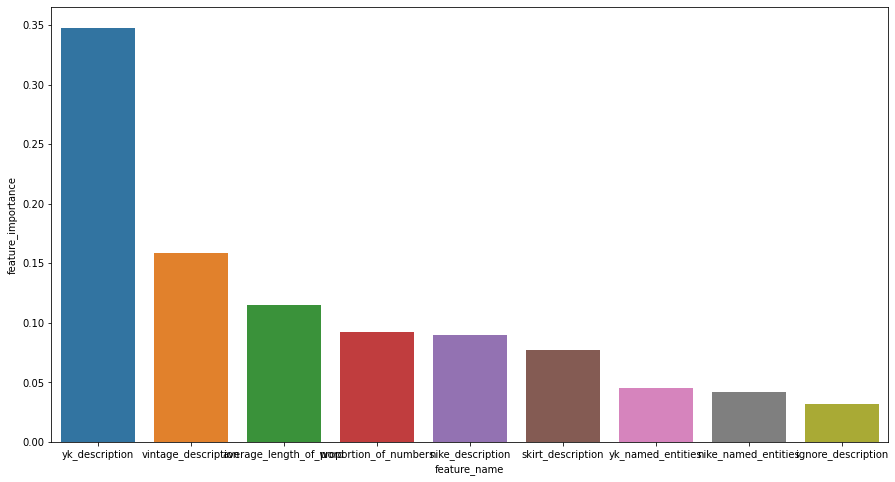

In [23]:
### Plot Feature Importance

plt.figure(figsize=(15,8))
sns.barplot(x='feature_name', y="feature_importance", data=features_list)

## Evaluate

In [25]:
def get_accuracy(y_test, y_pred,classname):
  print("Accuracy of ", classname)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {(accuracy * 100.0):.2f}%")
  print(accuracy_score(y_test, y_pred))

def get_class_report(y_test, y_pred,classname):
  print("Classification Report of ", classname)
  print(classification_report(y_test,y_pred))
  print(pd.crosstab(y_test, y_pred))

def plot_pr_curve(y_test, y_pred,classname):
  caption = "ROC curve for "+ classname
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  print("threshold values",fpr, tpr, thresholds)
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title(caption)
  plt.xlabel('False Positive Rate (1 - Specificity)')
  plt.ylabel('True Positive Rate (Sensitivity)')
  plt.grid(True)
  plt.show()
  print(metrics.roc_auc_score(y_test,y_pred))

In [26]:
### Printing Accuracy
get_accuracy(y_test, y_pred,"XGBoost Classifier")


Accuracy of  XGBoost Classifier
Accuracy: 92.40%
0.924


In [27]:
get_class_report(y_test, y_pred,"XGBoost Classifier")


Classification Report of  XGBoost Classifier
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       236
           1       0.92      0.94      0.93       264

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500

col_0    0    1
label          
0      215   21
1       17  247


threshold values [0.         0.08898305 1.        ] [0.         0.93560606 1.        ] [2 1 0]


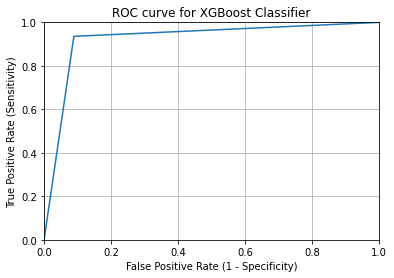

0.9233115048793015


In [28]:
plot_pr_curve(y_test, y_pred,"XGBoost Classifier")

In [39]:
X_train.shape

(2000, 1004)

In [29]:
### Training with Random Forest...
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(max_depth=11,n_estimators=15,max_features=500,
                                  criterion='gini',random_state=11)
RF_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=11, max_features=500, n_estimators=15,
                       random_state=11)

In [30]:
y_pred = RF_model.predict(X_test)

In [31]:
features_rf = pd.DataFrame(
    zip(X_train.columns, RF_model.feature_importances_),
    columns=["feature_name", "feature_importance"],
)
features_rf.sort_values("feature_importance", ascending=False)

feature_name  feature_importance
2             average_length_of_word            0.113021
1000                  yk_description            0.092578
981              vintage_description            0.063726
495                yk_named_entities            0.054038
3              proportion_of_numbers            0.048511
809                 nike_description            0.047809
1            proportion_of_stopwords            0.042291
726               ignore_description            0.020757
604            condition_description            0.020738
329              nike_named_entities            0.020463
910                 size_description            0.017105
662              fashion_description            0.016298
874                retro_description            0.013702
938               summer_description            0.011988
686                 girl_description            0.011454
733               island_description            0.009426
863               purple_description            0.009209
631                depop_description            0.008001
883                 rock_description            0.007625
560                brand_description            0.006993
847                polly_description            0.006661
432            summer_named_entities            0.006514
944                  tag_description            0.005999
505                adida_description            0.005781
856             princess_description            0.005733
807                  new_description            0.005716
947                  tee_description            0.005301
217            hoodie_named_entities            0.005117
403            sequin_named_entities            0.003990
889                satin_description            0.003958
870                 rave_description            0.003910
695                great_description            0.003880
767                 like_description            0.003789
552               boohoo_description            0.003602
858                   ps_description            0.003586
646                dress_description            0.003505
128             depop_named_entities            0.003457
990                 wear_description            0.003280
605             converse_description            0.003131
545                black_description            0.003036
902                shirt_description            0.003004
901             shipping_description            0.002993
754                 lace_description            0.002983
834              perfect_description            0.002902
626                  day_description            0.002844
12              alice_named_entities            0.002839
698               grunge_description            0.002829
652                egirl_description            0.002793
431             suede_named_entities            0.002778
719               hoodie_description            0.002777
786             melville_description            0.002694
692                 goth_description            0.002674
300          melville_named_entities            0.002674
676                 free_description            0.002671
616                 crop_description            0.002659
665             festival_description            0.002596
866             question_description            0.002564
667                  fit_description            0.002521
629                denim_description            0.002412
461                uk_named_entities            0.002337
561               brandy_description            0.002335
628                 deal_description            0.002328
378              rave_named_entities            0.002242
757              leather_description            0.002231
895                  set_description            0.002139
0                         product_id            0.002129
977                 vest_description            0.002126
886                 sale_description            0.002057
1001                zara_description            0.002032
381             retro_named_entiti

In [32]:
features_list2 = features_rf[features_rf['feature_importance'] > 0.000000 ]
features_list2 = features_list2.sort_values("feature_importance", ascending=False)
features_list2

feature_name  feature_importance
2            average_length_of_word            0.113021
1000                 yk_description            0.092578
981             vintage_description            0.063726
495               yk_named_entities            0.054038
3             proportion_of_numbers            0.048511
809                nike_description            0.047809
1           proportion_of_stopwords            0.042291
726              ignore_description            0.020757
604           condition_description            0.020738
329             nike_named_entities            0.020463
910                size_description            0.017105
662             fashion_description            0.016298
874               retro_description            0.013702
938              summer_description            0.011988
686                girl_description            0.011454
733              island_description            0.009426
863              purple_description            0.009209
631               depop_description            0.008001
883                rock_description            0.007625
560               brand_description            0.006993
847               polly_description            0.006661
432           summer_named_entities            0.006514
944                 tag_description            0.005999
505               adida_description            0.005781
856            princess_description            0.005733
807                 new_description            0.005716
947                 tee_description            0.005301
217           hoodie_named_entities            0.005117
403           sequin_named_entities            0.003990
889               satin_description            0.003958
870                rave_description            0.003910
695               great_description            0.003880
767                like_description            0.003789
552              boohoo_description            0.003602
858                  ps_description            0.003586
646               dress_description            0.003505
128            depop_named_entities            0.003457
990                wear_description            0.003280
605            converse_description            0.003131
545               black_description            0.003036
902               shirt_description            0.003004
901            shipping_description            0.002993
754                lace_description            0.002983
834             perfect_description            0.002902
626                 day_description            0.002844
12             alice_named_entities            0.002839
698              grunge_description            0.002829
652               egirl_description            0.002793
431            suede_named_entities            0.002778
719              hoodie_description            0.002777
786            melville_description            0.002694
692                goth_description            0.002674
300         melville_named_entities            0.002674
676                free_description            0.002671
616                crop_description            0.002659
665            festival_description            0.002596
866            question_description            0.002564
667                 fit_description            0.002521
629               denim_description            0.002412
461               uk_named_entities            0.002337
561              brandy_description            0.002335
628                deal_description            0.002328
378             rave_named_entities            0.002242
757             leather_description            0.002231
895                 set_description            0.002139
0                        product_id            0.002129
977                vest_description            0.002126
886                sale_description            0.002057
1001               zara_description            0.002032
381            retro_named_entities            0.002026
579               chain_description            

In [33]:
features_list2.shape

(413, 2)

In [34]:
###  Along with Average Length of the word, 
### The above 415 keywords and entities present in the product description are more contributing for the model prediction.

In [35]:
### Printing Accuracy
get_accuracy(y_test, y_pred,"Random Forest Classifier")


Accuracy of  Random Forest Classifier
Accuracy: 99.40%
0.994


In [37]:
get_class_report(y_test, y_pred,"Random Forest Classifier")

Classification Report of  Random Forest Classifier
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       236
           1       1.00      0.99      0.99       264

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

col_0    0    1
label          
0      235    1
1        2  262


threshold values [0.         0.00423729 1.        ] [0.         0.99242424 1.        ] [2 1 0]


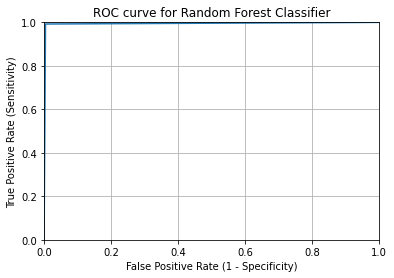

0.9940934771443247


In [38]:
### Plotting ROC Curve...
plot_pr_curve(y_test, y_pred,"Random Forest Classifier")

**Hyper Parameter Tuning **

Below steps are for the optimization of Random forest Classifier Model, not mandatory to execute.

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

In [ ]:
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [ ]:
# Rand_Forest = RandomForestClassifier()
# RF_Tuned = RandomizedSearchCV(estimator = Rand_Forest, param_distributions = random_grid, 
#                               n_iter = 75, cv = 3, verbose=2, random_state=42)
# RF_Tuned.fit(X_train, y_train)

In [ ]:
### Further Steps to improve the approach:


Please see the Doc file along with this code for all the suggestions and explanations.

1.   For extracting entities from the description BERT will be one of the best option.
2.   As the size of data become large its better to use deep learning models like LSTM instead of traditional ML model ( Keras word embedding will be much better in this case).
3.  From the data perspective it will be more useful if we get product brand category along with the description so that we can analyze which all products under specific category are getting misused and which all products making spammy descriptions. So this information can be used as new features while doing feature engineering.



